In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
_FOLDER = "./data/"

In [2]:
def sigmoid_Wang(x, p, s):
    """ Sigmoid function from Dennis Wang's paper:
    x - dosage [0, 1],
    p - position,        default=0.4
    s - shape parameter, default=-1
    """
    return ( 1.0 / (1.0 + np.exp((x-p)/s)) )


def fsigmoid(x, p, k):
    """ Comparing with Dennis Wang's sigmoid:
    x = x  - dosage [0, 1]
    p - position [0,1],           default=0.4
    k = -1/s (s -shape parameter) default=0.4
    """
    return ( 1.0 / (1.0 + np.exp(-k*(x-p))) )


def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)


def sigmoid_3_param(x, x0, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
        """
    return ( 1/ (1 + np.exp(-k*(x-x0))) + d )


def ll4(x, e, c, b, d):
    """ https://gist.github.com/yannabraham/5f210fed773785d8b638
    This function is basically a copy of the LL.4 function from the R drc package:
     - b: hill slope
     - d: min response - determines the vertical position of the graph
     - c: max response
     - e: EC50
     c-d - difference between max and min responses
     np.exp( b* (np.log(x)-np.log(e)) -  np.exp((x-p)/s in Dennis Wang's sigmoid
     b- hill slope = 1/s - shape parameter
     np.log(x)-np.log(e) == x-p in Dennis Wang's sigmoid
     """
    return ( (c-d)/(1 + np.exp( b*(np.log(x)-np.log(e) ))) + d)


def ll4_R(x, c, a, b, d):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
   
    a-d - difference between max and min responses
    np.exp( b* np.log(x) - e) -  np.exp((x-p)/s in Dennis Wang's sigmoid
    b - hill slope = 1/s - shape parameter
    np.log(x)- e/b == x-p in Dennis Wang's sigmoid

    """
    return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


def logistic4(x, A, B, C, d):
    """ https://people.duke.edu/~ccc14/pcfb/analysis.html
    4PL logistic equation
    Dennis Wang's sigmoid: 1.0 / (1.0 + np.exp((x-p)/s)
    (A - d) = 1 in Dennis Wang's sigmoid:
    (x/C)**B  - corresponds to np.exp((x-p)/s
    d - determines the vertical position of the graph
    """
    return ( (A-d)/(1.0+((x/C)**B)) + d )


def logLogistR(x, EC50, HS, E_inf):
    """Python analog for PharmacoGx/R/LogLogisticRegression.R
    https://github.com/bhklab/PharmacoGx/blob/master/R/LogLogisticRegression.R
    E = E_inf + (1 - E_inf)/(1 + (x/EC50)^HS)
    Dennis Wang's sigmoid: 1.0 / (1.0 + np.exp((x-p)/s)
    
    (A - d) = 1 in Dennis Wang's sigmoid:
    (np.log10(x)/EC50)**HS  - (in logistic4 (x/C)**B) corresponds to np.exp((x-p)/s 
    
    E_inf - determines the vertical position of the graph /coefficient d, min response in other functions
    """
    return ((1-E_inf)/(1+(np.log10(x)/EC50)**HS) + E_inf)



def FitCurve(fitting_function, x, y, parameters_guess=None, to_plot = False):
#     from scipy.optimize import curve_fit

    if parameters_guess:
        parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess)
    else: 
        parameters, p_covariance = curve_fit(fitting_function, x, y)
    x2 = np.linspace(0, 1, 10)
    y_fit = fitting_function(x, *parameters)
    r2 = r2_score(y, y_fit)

    if to_plot:
        print("Fitting parameters:", *parameters)
        plt.scatter(x, y)
        x2 = np.linspace(0, 1, 10)
        y2 = fitting_function(x2, *parameters)
        plt.plot(x2, y2, "blue", label = "R^2= %0.5f"%r2)   
        plt.title('Least-squares fit')
        plt.legend();
    return r2, parameters


def FittingColumn(df, indexes, x_columns, y_columns, fitting_function, parameters_guess=None, default_param = False):
    """
    intial parameter guess [max(y), np.median(x), 1, min(y)]
    potentially they can be different for each data row, but as soon as we have scaled and filtered data
    we can use by default [1.0, 0.4, 1.0, .0] 
    """
    
    r2_scores = np.zeros(len(indexes))
    X = df.loc[indexes, x_columns].values.astype(np.float32)
    Y = df.loc[indexes, y_columns].values.astype(np.float32)
    fitting_parameters = [None]*len(indexes)
    
    
    # parameters_guess= [np.median(x), 1, max(y), min(y)]
    default_param_model = {"sigmoid_Wang": [0.4, 0.1],
                       "fsigmoid" : [0.4, -10],
                       "sigmoid_4_param": [0.4, 1.0, 1.0, .0],
                       "sigmoid_3_param": [0.4, 1.0, .0],
                       "logistic4": [1.0, 1.0, 1.0, 0.0],
                       "ll4": [0.4, 1.0, 1.0, 0.0],
                       "ll4_R": [0.4, 1.0, 1.0, 0.0],
                       "logLogistR": [-1, -0.1, 0.1]}
    
    if default_param:
        parameters_guess = default_param_model[fitting_function]
       
    else:
        pass
    
    for i in tqdm(range(len(indexes))):
        x = X[i, :]
        y = Y[i, :]
    
        try:
            r2_scores[i], fitting_parameters[i] = FitCurve(fitting_function_object, x, y, parameters_guess = parameters_guess)
            
        except:
            try:
                functions = {"fsigmoid": fsigmoid, 
                 "sigmoid_Wang": sigmoid_Wang, 
                "sigmoid_4_param": sigmoid_4_param,
                 "sigmoid_3_param": sigmoid_3_param, 
                 "logistic4": logistic4,  
                 "ll4": ll4, 
                 "ll4_R":ll4_R,
                 "logLogistR":logLogistR}
                fitting_function_object = functions[fitting_function]
#                 from fitting_curves.py import fitting_function_object
                r2_scores[i], fitting_parameters[i] = FitCurve(fitting_function_object, x, y, parameters_guess = parameters_guess)
            except:
                r2_scores[i] = 0
    return r2_scores, fitting_parameters


def ShowResponseCurvesWithFitting(df, plots_in_row, plots_in_column, x_columns, y_columns, start_index=0, indexes=[],
                         fitting_function =None, fitting_parameters =None, pred_fitting_param = None):
    
    print("Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)")
    fig = plt.figure(figsize=(14, 11))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    n_plots= plots_in_row*plots_in_column
    
    if len(indexes) == 0:
        indexes = df.index[start_index : start_index+n_plots]
        
    X = df.loc[indexes, x_columns].values.astype(np.float32)
    Y = df.loc[indexes, y_columns].values.astype(np.float32)
        
    try:
        for i in range(len(indexes)):
            x = X[i, :]
            y = Y[i, :]
            ind = indexes[i]

                
            ax = fig.add_subplot(plots_in_row, plots_in_column, i+1)
            ax.scatter(x,y)
            ax.set_title(str(ind)+"_"+str(df.loc[ind, "DRUG_ID"])+"_"+str(df.loc[ind, "COSMIC_ID"]))
            ax.set_xlabel("Scaled dosage")
            ax.set_ylabel("Normalised response")

            if fitting_function:
                functions = {"fsigmoid": fsigmoid, "sigmoid_Wang": sigmoid_Wang, 
                             "sigmoid_4_param": sigmoid_4_param, "sigmoid_3_param": sigmoid_3_param, 
                             "logistic4": logistic4, "ll4": ll4, "ll4_R": ll4_R, "logLogistR": logLogistR}
                fitting_function_object = functions[fitting_function]
                
#                 from fitting_curves.py import fitting_function_object

                x2 = np.linspace(0, 1, 10)

                if type(fitting_parameters) == str:
                    fit_param = df.loc[ind, fitting_parameters]
                else:

                    fit_param = df.loc[ind, fitting_parameters].values

                y_fit = fitting_function_object(x, *fit_param)
                y2 = fitting_function_object(x2, *fit_param)
                r2 = r2_score(y, y_fit)
                ax.plot(x2, y2, label= "R^2 fit = %0.4f"% r2)
                ax.legend()
            if pred_fitting_param:

                x3 = np.linspace(0, 1, 10) 
                fit_param = df.loc[ind, pred_fitting_param]    
                y_fit3 = fitting_function_object(x, *fit_param)
                y3 = fitting_function_object(x3, *fit_param)
                r2_pred = r2_score(y, y_fit3)
                ax.plot(x3, y3, color="red", label= "R^2 pred = %0.4f"% r2_pred)
                ax.legend()

                
    except:
        print("ERROR: Number of indexes does not correspond to number of graphs to plot")


def compute_r2_score(df, x_columns, y_columns, fitting_parameters, fitting_function="sigmoid_4_param"):
    functions = {"fsigmoid": fsigmoid, "sigmoid_Wang": sigmoid_Wang, 
                             "sigmoid_4_param": sigmoid_4_param, "sigmoid_3_param": sigmoid_3_param, 
                             "logistic4": logistic4, "ll4": ll4, "ll4_R":ll4_R, "logLogistR": logLogistR}
    fitting_function_object = functions[fitting_function]
    r2_scores=np.zeros(len(df.index))
    for i in range(len(df.index)):
        x = df.loc[df.index[i], x_columns]
        y = df.loc[df.index[i], y_columns]
        if type(fitting_parameters) == str:
            fit_param = df.loc[df.index[i], fitting_parameters]
        else:
            fit_param = df.loc[df.index[i], fitting_parameters].values
        y_fit = fitting_function_object(x, *fit_param)
        r2_scores[i] = r2_score(y, y_fit)
    return r2_scores

## Fitting data

In [3]:
df = pd.read_csv("../results/filtered_drug_profiles_123.csv")
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

### sigmoid_4_param

100%|██████████| 2776/2776 [00:08<00:00, 323.86it/s]


R2>0: (2755, 49)
R2>0.9 2703
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 8.26 s, sys: 268 ms, total: 8.53 s
Wall time: 8.97 s


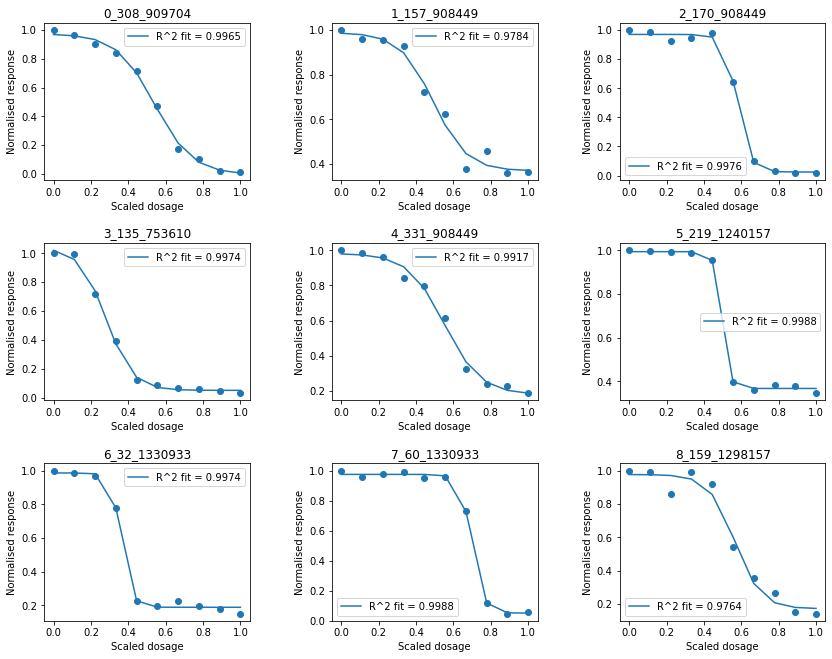

In [4]:
%%time
fitting_function = "sigmoid_4_param"
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]>0]
print("R2>0:", df.shape)
print("R2>0.9", df[df[fitting_function+"_r2"]>0.9].shape[0])
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


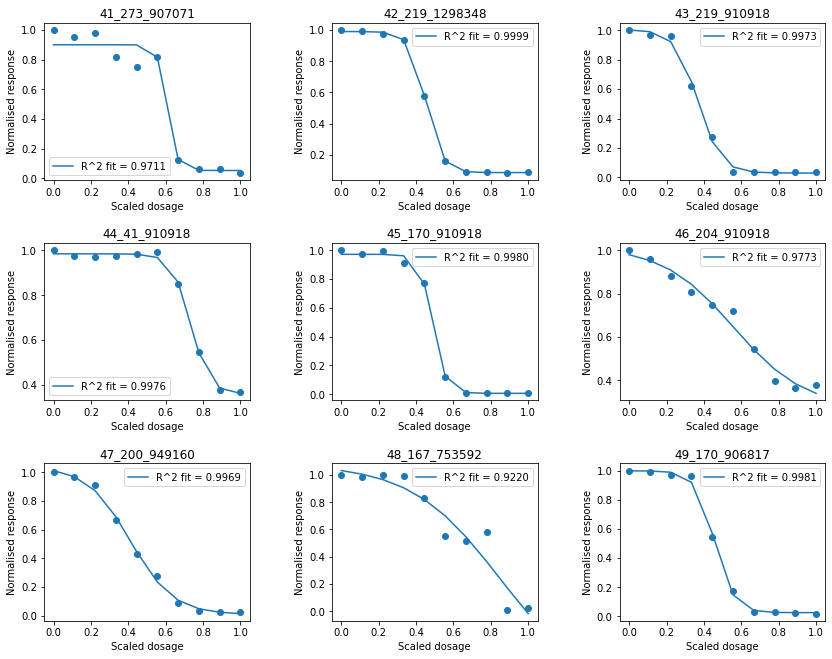

In [5]:
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[40:49],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

In [6]:
df.loc[df.index[2], ["DRUG_ID", "COSMIC_ID"]]

DRUG_ID         170
COSMIC_ID    908449
Name: 2, dtype: object

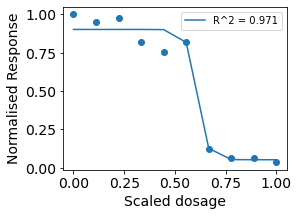

In [7]:
plt.figure(figsize=(4,3))
ind =int(df[(df["DRUG_ID"]==273)& (df["COSMIC_ID"]==907071)].index[0])
fitting_parameters =fitting_function

x = df.loc[ind, conc_columns].astype("float32")
y = df.loc[ind, response_norm].astype("float32")
plt.scatter(x, y)
plt.tick_params(labelsize=14)
plt.xlabel("Scaled dosage", fontsize=14)
plt.ylabel("Normalised Response", fontsize=14)
# plt.savefig("filt_0.png", bbox_inches='tight');
fit_param = df.loc[ind, fitting_parameters]
y_fit = sigmoid_4_param(x, *fit_param)
r2 = r2_score(y, y_fit)
plt.plot(x, y_fit, label= "R^2 = %0.3f"% r2)
plt.legend()
plt.savefig("filt_fit_0.png", bbox_inches='tight');

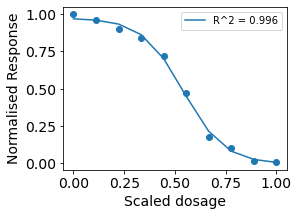

In [8]:
plt.figure(figsize=(4,3))
# ind = df[(df["DRUG_ID"]==308)& (df["COSMIC_ID"]==909704)].index
ind =int(df[(df["DRUG_ID"]==308)& (df["COSMIC_ID"]==909704)].index[0])
fitting_parameters =fitting_function

x = df.loc[ind, conc_columns].astype("float32")
y = df.loc[ind, response_norm].astype("float32")
plt.scatter(x, y)
plt.tick_params(labelsize=14)
plt.xlabel("Scaled dosage", fontsize=14)
plt.ylabel("Normalised Response", fontsize=14)
plt.savefig("filt_0.png", bbox_inches='tight')
fit_param = df.loc[ind, fitting_parameters]
y_fit = sigmoid_4_param(x, *fit_param)
r2 = r2_score(y, y_fit)
plt.plot(x, y_fit, label= "R^2 = %0.3f"% r2)
plt.legend()
# plt.savefig("filt_0.png", bbox_inches='tight')
plt.savefig("filt_fit_0.png", bbox_inches='tight');

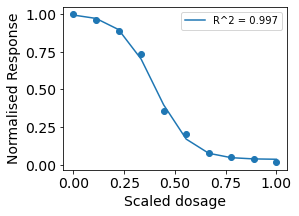

In [90]:
plt.figure(figsize=(4,3))
ind =int(df[(df["DRUG_ID"]==274)& (df["COSMIC_ID"]==1240223)].index[0])
fitting_parameters =fitting_function

x = df.loc[ind, conc_columns].astype("float32")
y = df.loc[ind, response_norm].astype("float32")
plt.scatter(x, y)
plt.tick_params(labelsize=14)
plt.xlabel("Scaled dosage", fontsize=14)
plt.ylabel("Normalised Response", fontsize=14)
plt.savefig("filt_1.png", bbox_inches='tight');
fit_param = df.loc[ind, fitting_parameters]
y_fit = sigmoid_4_param(x, *fit_param)
r2 = r2_score(y, y_fit)
plt.plot(x, y_fit, label= "R^2 = %0.3f"% r2)
plt.legend()
plt.savefig("filt_fit_1.png", bbox_inches='tight');

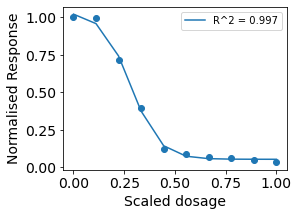

In [91]:
plt.figure(figsize=(4,3))
# ind = df.index[3]
ind =int(df[(df["DRUG_ID"]==135)& (df["COSMIC_ID"]==753610)].index[0])
fitting_parameters =fitting_function

x = df.loc[ind, conc_columns].astype("float32")
y = df.loc[ind, response_norm].astype("float32")
plt.scatter(x, y)
plt.tick_params(labelsize=14)
plt.xlabel("Scaled dosage", fontsize=14)
plt.ylabel("Normalised Response", fontsize=14)
# plt.savefig("filt_2.png", bbox_inches='tight');
fit_param = df.loc[ind, fitting_parameters]
y_fit = sigmoid_4_param(x, *fit_param)
r2 = r2_score(y, y_fit)
plt.plot(x, y_fit, label= "R^2 = %0.3f"% r2)
plt.legend()
plt.savefig("filt_fit_2.png", bbox_inches='tight');

### sigmoid_Wang = sigmoid_2_param

100%|██████████| 2755/2755 [00:03<00:00, 722.75it/s]


R2>0: (2755, 51)
R2>0.9 2457
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 4.02 s, sys: 220 ms, total: 4.24 s
Wall time: 4.26 s


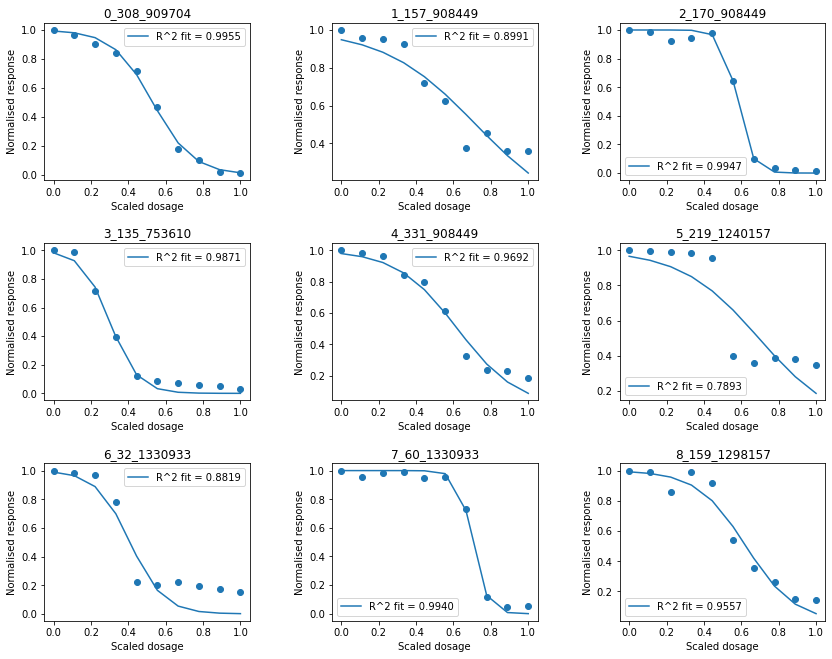

In [8]:
%%time
fitting_function = "sigmoid_Wang" 
# "sigmoid_Wang" we don't need default_param_number
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]
print("R2>0:", df.shape)
print("R2>0.9", df[df[fitting_function+"_r2"]>0.9].shape[0])
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

### sigmoid_3_param

100%|██████████| 2755/2755 [00:05<00:00, 487.25it/s]


R2>0: (2755, 53)
R2>0.9 2683
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 5.77 s, sys: 203 ms, total: 5.97 s
Wall time: 5.91 s


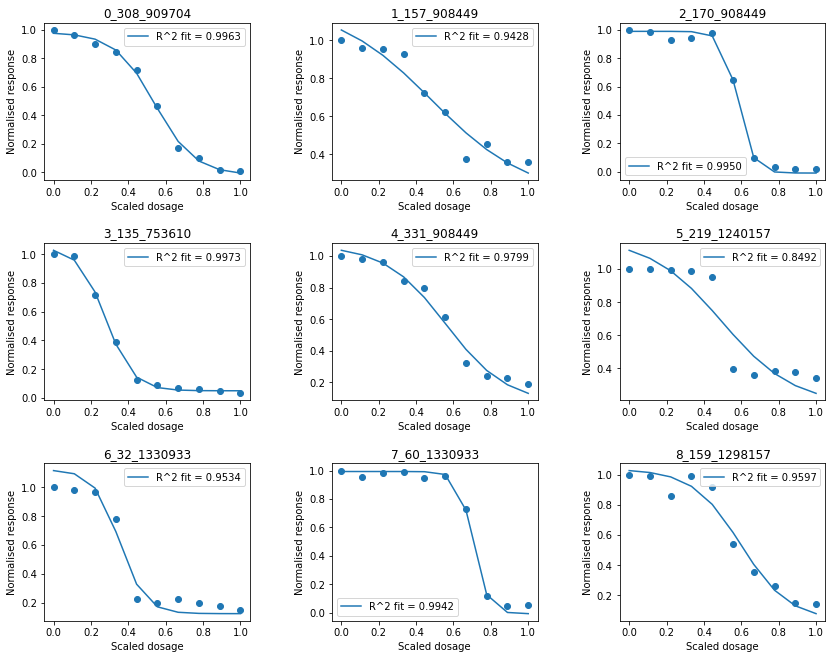

In [9]:
%%time
fitting_function = "sigmoid_3_param"

r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]

print("R2>0:", df.shape)
print("R2>0.9", df[df[fitting_function+"_r2"]>0.9].shape[0])
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

### fsigmoid

100%|██████████| 7927/7927 [00:20<00:00, 379.81it/s]


(7926, 55)
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


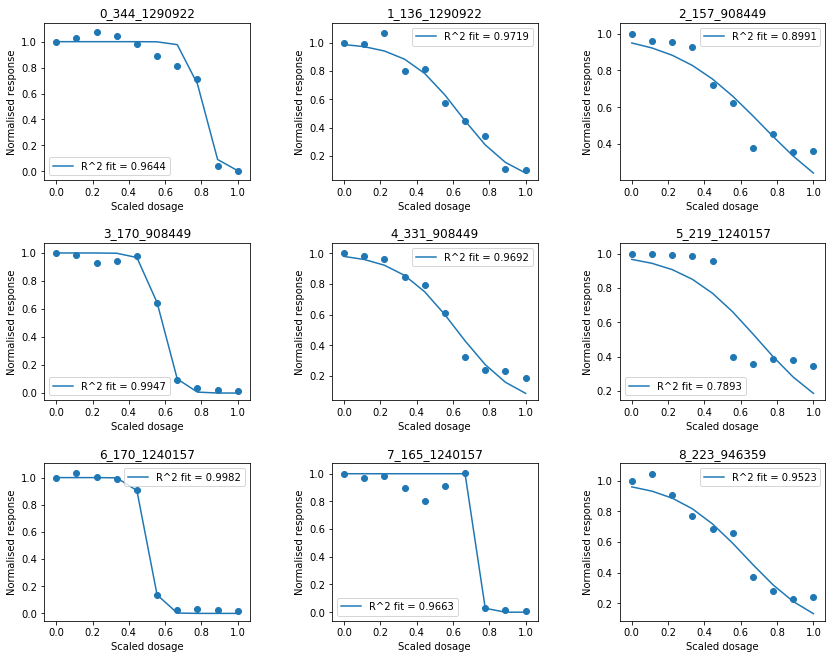

In [7]:
# %%time
fitting_function = "fsigmoid"

r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]
print(df.shape)

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

### logistic4 = logistic_4_param

100%|██████████| 2755/2755 [00:07<00:00, 377.02it/s]


R2>0: (2755, 55)
R2>0.9 2720
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 7.31 s, sys: 333 ms, total: 7.65 s
Wall time: 7.74 s


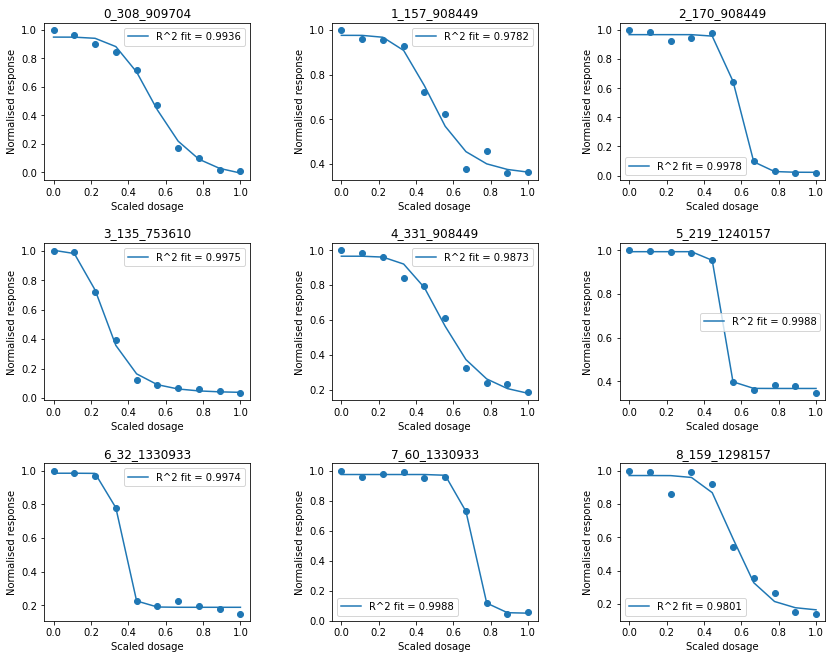

In [10]:
%%time
fitting_function = "logistic4"
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]

print("R2>0:", df.shape)
print("R2>0.9", df[df[fitting_function+"_r2"]>0.9].shape[0])
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

In [9]:
df[df["logistic4_r2"]>0.9][["logistic4", "logistic4_r2"]]

,logistic4,logistic4_r2
0,"[0.9775021748098828, 24.85768434063236, 0.8072...",0.965287
1,"[1.016142257085685, 2.92006152175885, 0.723523...",0.977089
2,"[0.9760242387663421, 5.344787715121362, 0.4950...",0.978230
3,"[0.9680061035648554, 17.35700335698762, 0.5773...",0.997801
4,"[0.9660489414392239, 5.499998145333257, 0.5592...",0.987341
...,...,...
7942,"[0.9699070593146266, 4.084059695951159, 0.5460...",0.979613
7943,"[1.0185835543299588, 2.6395643160050097, 0.366...",0.987247
7944,"[0.9723275291080136, 4.81956460656914, 0.37847...",0.996667
7945,"[1.0637914159172863, 5.58590567418359, 0.70347...",0.949589


### LL4

100%|██████████| 2755/2755 [00:08<00:00, 327.35it/s]


R2>0: (2755, 61)
R2>0.9 2721
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 8.43 s, sys: 241 ms, total: 8.67 s
Wall time: 8.62 s


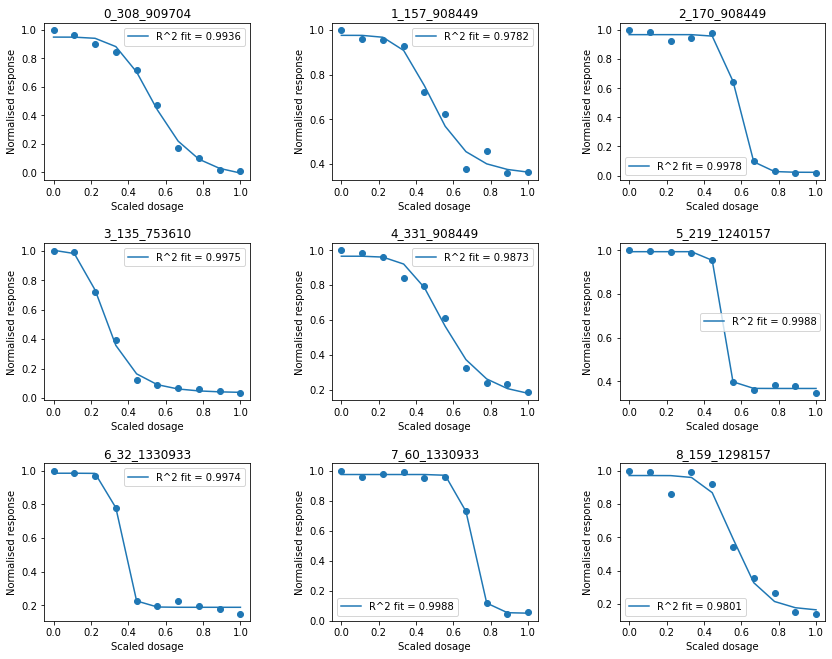

In [13]:
%%time
fitting_function = "ll4"
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]
print("R2>0:", df.shape)
print("R2>0.9", df[df[fitting_function+"_r2"]>0.9].shape[0])
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

### ll4_R = ll4_R_4_param

100%|██████████| 2755/2755 [00:09<00:00, 290.10it/s]


R2>0: (2755, 57)
R2>0.9 2716
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 8.95 s, sys: 331 ms, total: 9.29 s
Wall time: 9.76 s


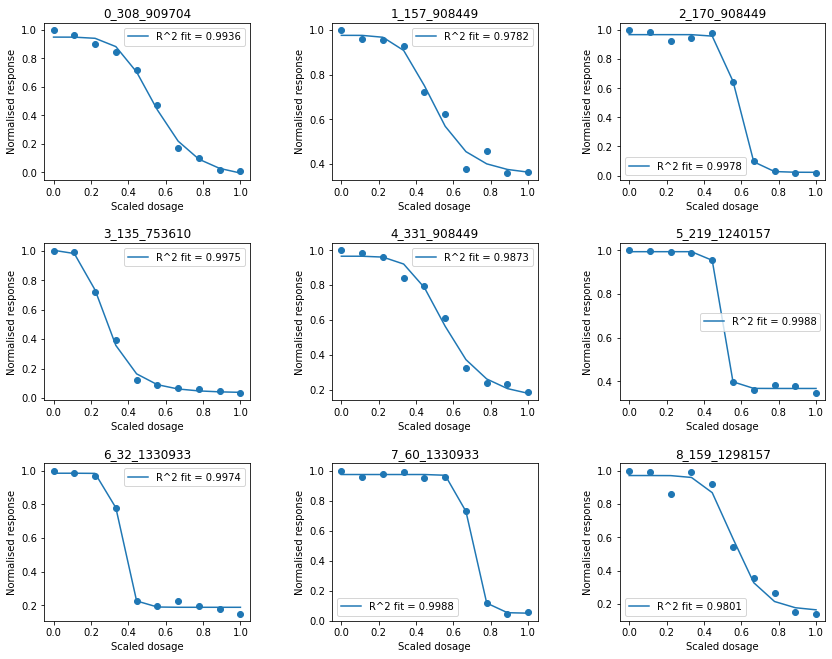

In [11]:
%%time
fitting_function = "ll4_R"
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]

print("R2>0:", df.shape)
print("R2>0.9", df[df[fitting_function+"_r2"]>0.9].shape[0])
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

### logLogistR   = logLogist_3_param

100%|██████████| 2755/2755 [00:09<00:00, 281.85it/s]


R2>0: (2755, 59)
R2>0.9 2714
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)
CPU times: user 9 s, sys: 359 ms, total: 9.36 s
Wall time: 10 s


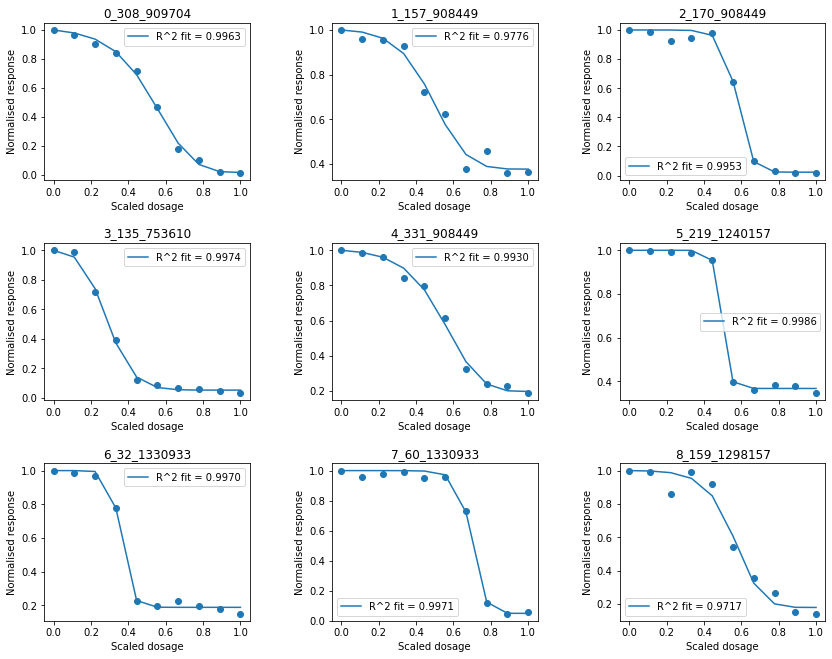

In [12]:
%%time
fitting_function = "logLogistR"
r2, fit_param = FittingColumn(df, df.index, x_columns=conc_columns, y_columns= response_norm,
                               fitting_function = fitting_function, default_param=True)
df[fitting_function+"_r2"] = r2
df[fitting_function] = fit_param
df= df[df[fitting_function+"_r2"]!=0]

print("R2>0:", df.shape)
print("R2>0.9", df[df[fitting_function+"_r2"]>0.9].shape[0])
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = fitting_function, 
                                  fitting_parameters =fitting_function)

## Comparison of fitting models

In [13]:
functions = ["sigmoid_Wang", "fsigmoid", 
             "sigmoid_4_param", "sigmoid_3_param",
             "logistic4", "ll4", "ll4_R",
             "logLogistR"]
functions_dict= dict(list(enumerate(functions)))
r2_columns = [fitting_function+"_r2" for fitting_function in functions]

In [14]:
df["better_fitting"] = np.argmax(df[r2_columns].values, axis=1)
r2_col_res = r2_columns +["better_fitting"]
df["better_fitting"] = df["better_fitting"].map(functions_dict)
df[r2_col_res].head()

,sigmoid_Wang_r2,fsigmoid_r2,sigmoid_4_param_r2,sigmoid_3_param_r2,logistic4_r2,ll4_r2,ll4_R_r2,logLogistR_r2,better_fitting
0,0.964416,0.964416,-5.104407e-09,0.966673,0.965287,0.965288,0.965288,0.977597,logLogistR
1,0.971908,0.971908,9.754293e-01,0.974702,0.977089,0.977089,0.977089,0.970260,logistic4
2,0.899079,0.899079,9.784402e-01,0.942793,0.978230,0.978230,0.978230,0.977584,sigmoid_4_param
3,0.994659,0.994659,9.975843e-01,0.995039,0.997801,0.997801,0.997801,0.995329,ll4_R
4,0.969244,0.969244,9.916776e-01,0.979949,0.987341,0.987341,0.987341,0.993016,logLogistR


In [15]:
df["better_fitting"].value_counts()

sigmoid_4_param    2583
logLogistR         2056
logistic4          1167
ll4_R              1125
ll4                 989
sigmoid_3_param       4
Name: better_fitting, dtype: int64

In [20]:
r2_limit = 0.98
fitted_samples = {}
for function in functions:
    fitted_samples[function] = df[df[function+"_r2"]> r2_limit].shape[0]

pd.DataFrame(fitted_samples.values(), index=fitted_samples.keys(), columns= ["fitted_samples R2>"+str(r2_limit)])\
            .sort_values("fitted_samples R2>"+str(r2_limit), ascending=False)

,fitted_samples R2>0.98
sigmoid_4_param,6326
logistic4,6321
ll4,6321
ll4_R,6309
logLogistR,6058
sigmoid_3_param,4843
fsigmoid,3763
sigmoid_Wang,3752


In [21]:
r2_limit = 0.95
fitted_samples = {}
for function in functions:
    fitted_samples[function] = df[df[function+"_r2"]> r2_limit].shape[0]

pd.DataFrame(fitted_samples.values(), index=fitted_samples.keys(), columns= ["fitted_samples R2>"+str(r2_limit)])\
            .sort_values("fitted_samples R2>"+str(r2_limit), ascending=False)

,fitted_samples R2>0.95
ll4,7441
logistic4,7440
ll4_R,7427
sigmoid_4_param,7391
logLogistR,7329
sigmoid_3_param,6762
fsigmoid,5705
sigmoid_Wang,5693


In [22]:
r2_limit = 0.9
fitted_samples = {}
for function in functions:
    fitted_samples[function] = df[df[function+"_r2"]> r2_limit].shape[0]

pd.DataFrame(fitted_samples.values(), index=fitted_samples.keys(), columns= ["fitted_samples R2>"+str(r2_limit)])\
            .sort_values("fitted_samples R2>"+str(r2_limit), ascending=False)

,fitted_samples R2>0.9
ll4,7766
logistic4,7764
ll4_R,7757
logLogistR,7724
sigmoid_4_param,7713
sigmoid_3_param,7605
fsigmoid,7003
sigmoid_Wang,6998


In [ ]:
sigmoid_Wang: y = 1.0 / (1.0 + np.exp((x-p)/s))
    """ Sigmoid function from Dennis Wang's paper:
    x - dosage [0, 1],
    p - position,        default=0.4
    s - shape parameter, default=-1
    """
The most precise functions:
    1) sigmoid_4_param
    2) logLogistR     
    3) logistic4
    4) ll4_R
    
sigmoid_4_param: y = 1/ (L + np.exp(-k*(x-x0))) + d
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
    """
ll4: y = (c-d)/(1 + np.exp( b*(np.log(x)-np.log(e) ))) + d
    """ https://gist.github.com/yannabraham/5f210fed773785d8b638
    This function is basically a copy of the LL.4 function from the R drc package:
     - b: hill slope
     - d: min response - determines the vertical position of the graph
     - c: max response
     - e: EC50
     c-d - difference between max and min responses
     np.exp( b* (np.log(x)-np.log(e)) -  np.exp((x-p)/s in Dennis Wang's sigmoid
     b- hill slope = 1/s - shape parameter
     np.log(x)-np.log(e) == x-p in Dennis Wang's sigmoid
     """
logistic4: (A-d)/(1.0+((x/C)**B)) + d
    """ https://people.duke.edu/~ccc14/pcfb/analysis.html
    4PL logistic equation
    Dennis Wang's sigmoid: 1.0 / (1.0 + np.exp((x-p)/s)
    (A - d) = 1 in Dennis Wang's sigmoid:
    (x/C)**B  - corresponds to np.exp((x-p)/s
    d - determines the vertical position of the graph
    """